In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.matcher import FlannMatcher
from autocnet.matcher import ciratefi


from autocnet.matcher import subpixel as sp 
from scipy.misc import imresize
import math
import warnings
import cv2

from bisect import bisect_left

from scipy.ndimage.interpolation import rotate

from IPython.display import display
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Basic Structures

In [2]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':300})

#Match
cg.match_features()

# Perform the symmetry check
cg.symmetry_checks()
# Perform the ratio check
cg.ratio_checks(clean_keys = ['symmetry'])
# Create fundamental matrix
cg.compute_fundamental_matrices(clean_keys = ['symmetry', 'ratio'])


# Step: Compute the homographies and apply RANSAC
cg.compute_homographies(clean_keys=['symmetry', 'ratio'])

# Step: Compute subpixel offsets for candidate points
cg.subpixel_register(clean_keys=['ransac'])

cg.suppress(clean_keys=['symmetry', 'ratio', 'subpixel'])

# Do Stuff 

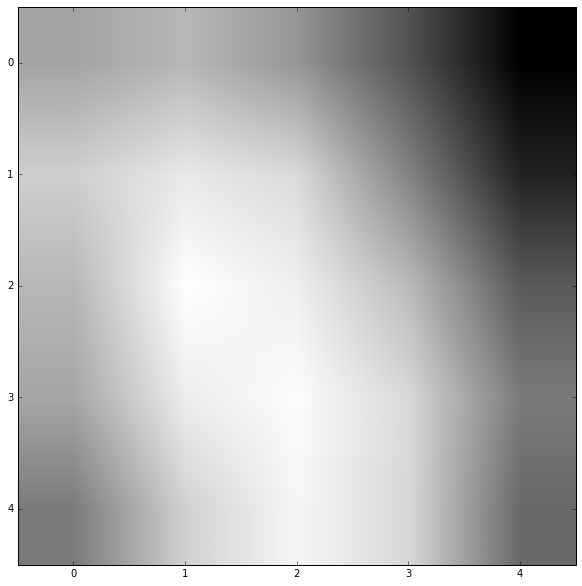

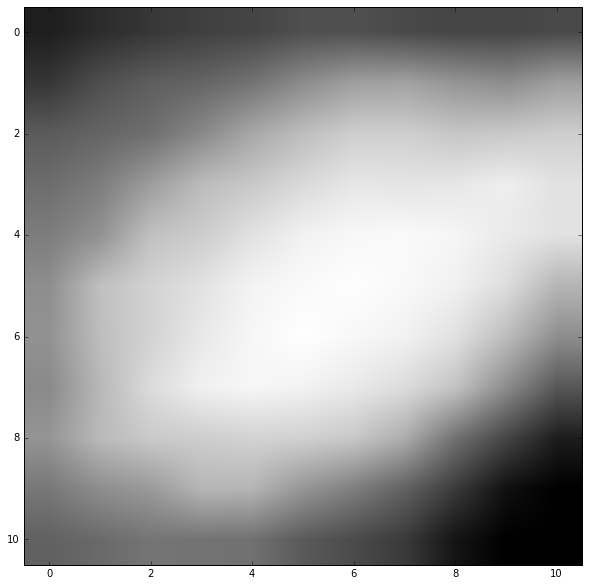

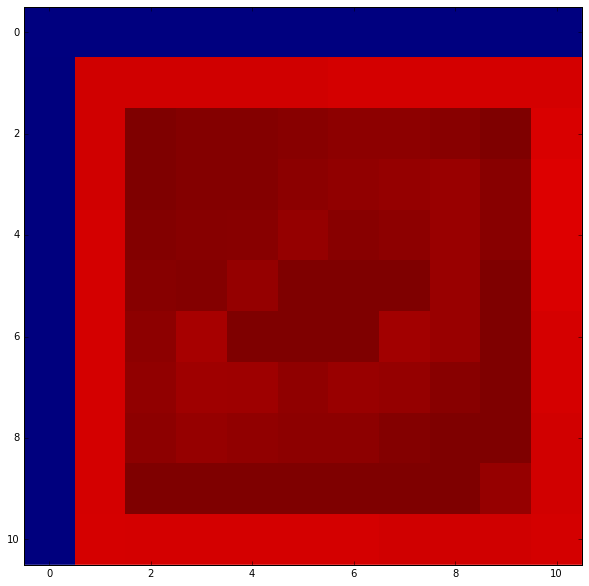

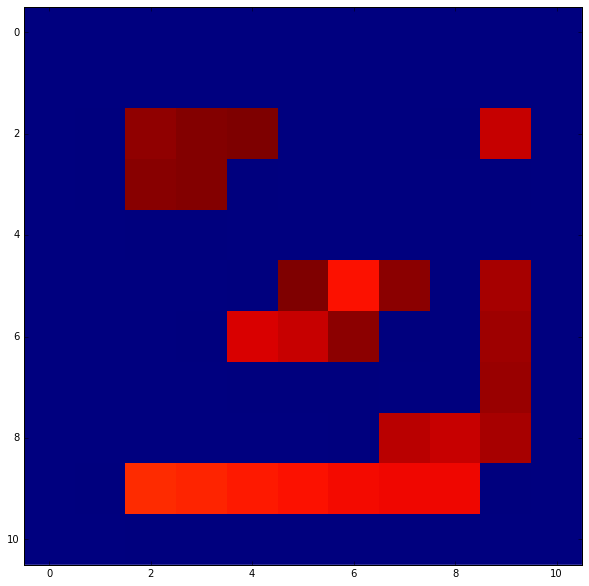

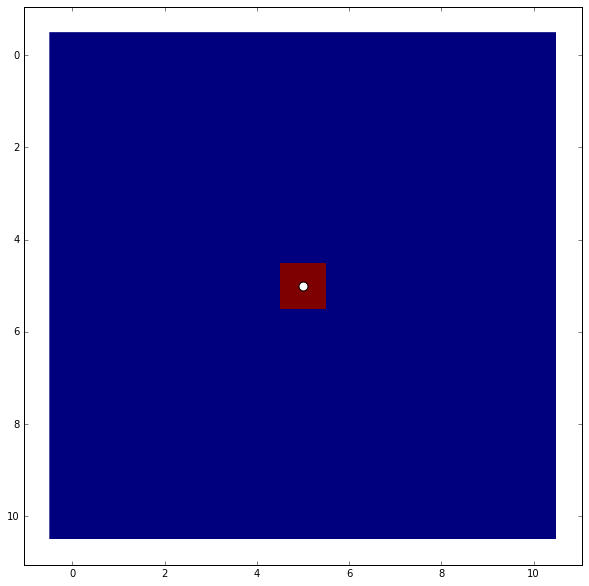

[[ 5.  5.]]


In [6]:
from scipy.ndimage.interpolation import zoom
from scipy.stats.stats import pearsonr 

figsize(10,10)
e = cg.edge[1][2]
matches = e.matches
clean_keys = ['subpixel']

full_offsets = np.zeros((len(matches), 3))

if clean_keys:
    matches, mask = e._clean(clean_keys)

# Preallocate the numpy array to avoid appending and type conversion
edge_offsets = np.empty((len(matches),3))

# for each edge, calculate this for each keypoint pair
for i, (idx, row) in enumerate(matches.iterrows()):
    s_idx = int(row['source_idx'])
    d_idx = int(row['destination_idx'])
    s_kps = e.source.get_keypoints().iloc[s_idx]
    d_kps = e.destination.get_keypoints().iloc[d_idx]

    s_keypoint = e.source.get_keypoints().iloc[s_idx][['x', 'y']].values
    d_keypoint = e.destination.get_keypoints().iloc[d_idx][['x', 'y']].values
    
    # Get the template and search windows
    s_template = sp.clip_roi(e.source.geodata, s_keypoint, 5)
    s_template = rotate(s_template, 0)
    s_template = imresize(s_template, 1.)

    d_search = sp.clip_roi(e.destination.geodata, d_keypoint, 11)
    d_search = rotate(d_search, 90)
    d_search = imresize(d_search, 1.)
    
    imshow(s_template, cmap='Greys')
    show()
    imshow(d_search, cmap='Greys')
    show()
    
    result = ciratefi.ciratefi(s_template, d_search, upsampling=10., alpha=math.pi/4, 
                     cifi_thresh=80, rafi_thresh=90, tefi_thresh=100,
                     use_percentile=True, radii=list(range(1,3)), verbose=True)
    print(result)
    break